In [86]:
import numpy as np
import matplotlib.pyplot as plt
import smartload.smartload as smart
import glob
from pprint import pprint
import scipy.optimize

%matplotlib inline



In [9]:
# Let's read an example datafile
filedir = '/Volumes/GoogleDrive/Other computers/ImagingDESKTOP-AR620FK/LocalExpData/f26/2021-11-20/2'

filepath = glob.glob(filedir + '/*Block.mat')[0]

In [10]:
data = smart.loadmat(filepath)

In [38]:
responses = data['block']['events']['responseValues']
feedback = data['block']['events']['feedbackValues']
opto = data['block']['events']['optoblockValues'][1:] #note the offset in opto recorded...
targets = data['block']['events']['contrastLeftValues']

In [163]:
# Let's fit the rl model now
def sim_values(responses, feedback, alpha=0.4):
    v0lst = [0.5]
    v1lst = [0.5]
    for i in range(len(responses)):
        if responses[i] == -1:
            v0lst.append(v0lst[-1] + alpha * (feedback[i] - v0lst[-1]))
            v1lst.append(v1lst[-1])
        else:
            v0lst.append(v0lst[-1])
            v1lst.append(v1lst[-1] + alpha * (feedback[i] - v1lst[-1]))
    
    return v0lst, v1lst
            

def log_likelihood(params, responses, feedback, optimize=1):
    alpha = params[0]
    eps = params[1]
    assert len(responses) == len(feedback)
    v0, v1 = sim_values(responses, feedback, alpha)
    v0 = np.array(v0[:-1])
    v1 = np.array(v1[:-1])
    
    #softmax layer
    prob = 1 / (1 + np.exp(-eps * (v1 - v0)))
    responses_binary = responses >= 0
    LLH = responses_binary * np.log(prob) + (1 - responses_binary) * np.log(1-prob)
    
    if optimize:
        return -np.sum(LLH)
    else:
        return prob, -np.sum(LLH)
        
        
        
        
        


In [164]:
scipy.optimize.minimize(log_likelihood, [0.4, 0.1], args=(responses, feedback, 1))

      fun: 179.32560571727012
 hess_inv: array([[ 0.01560271, -0.00597618],
       [-0.00597618,  0.02071248]])
      jac: array([0.00000000e+00, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([1.27000372, 1.39700588])

In [165]:
prob, llh = log_likelihood([1.27, -1.39], responses, feedback, 0)

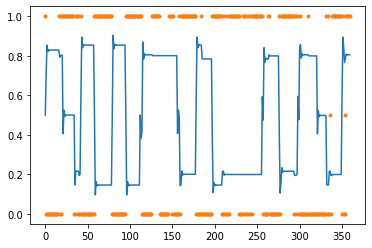

In [166]:
plt.plot(prob)
plt.plot((responses + 1) / 2, '.')

In [50]:
v0, v1 = sim_values(responses, feedback)

In [61]:
len(responses)

360

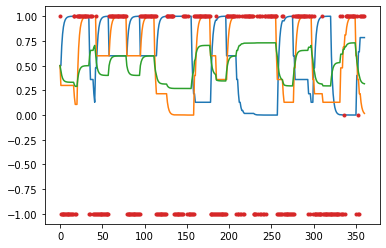

In [56]:
plt.plot(v0)
plt.plot(v1)
plt.plot(np.exp(v1) / (np.exp(v0) + np.exp(v1)))
plt.plot(responses, '.')